In [1]:
import visual_behavior.data_access.loading as loading
import scipy.signal
import visual_behavior.database as db
%widescreen
%standard_imports

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


imported:
	os
	pandas as pd
	numpy as np
	matplotlib.pyplot as plt


In [2]:
%matplotlib notebook

In [66]:
db.get_pkl_path(oeid, id_type='ophys_experiment_id')


'/allen/programs/braintv/production/visualbehavior/prod0/specimen_784057626/behavior_session_833100683/833002992.pkl'

<IPython.core.display.Javascript object>


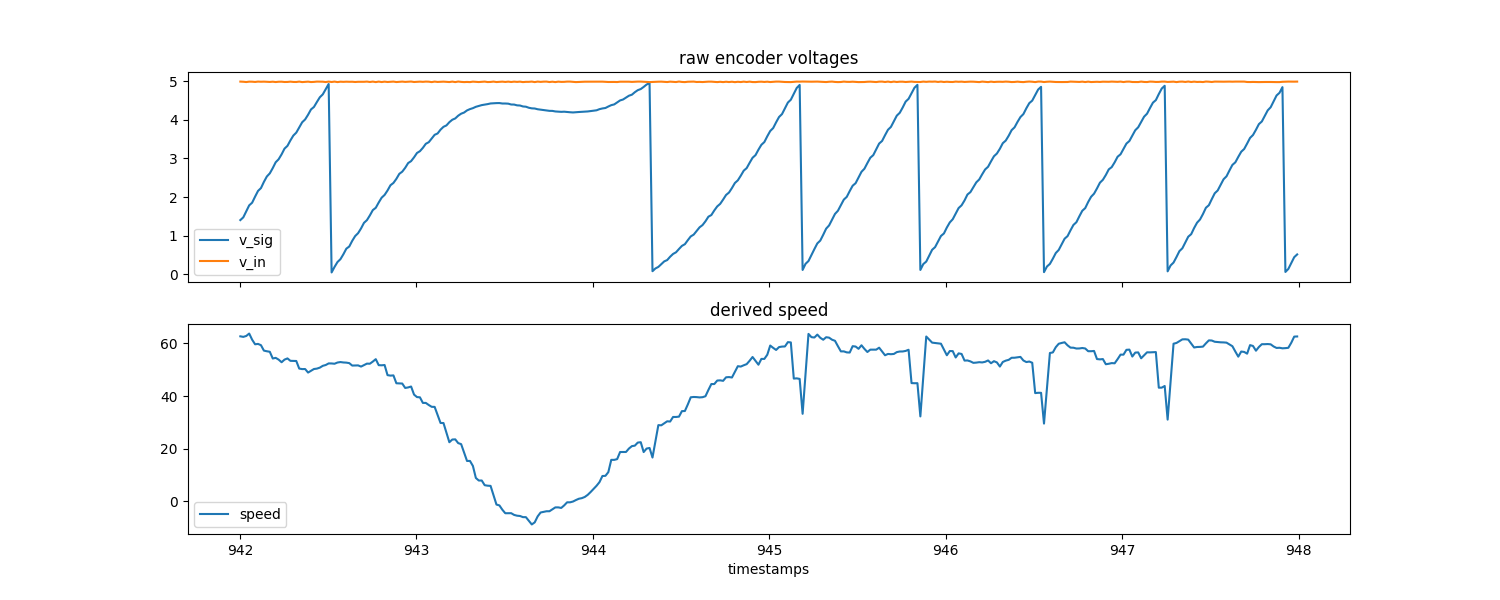

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam1_exposure', 'cam2_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


Text(0.5, 1.0, 'derived speed')

In [3]:
oeid = 833629926 #slc example
session = loading.get_ophys_dataset(oeid)
fig,ax=plt.subplots(2,1,figsize=(15,6),sharex=True)

pkl_path = db.get_pkl_path(oeid, id_type='ophys_experiment_id')
data = pd.read_pickle(pkl_path)
pkl_time = np.hstack((0,np.cumsum(data['items']['behavior']['intervalsms']/1000)))
session.running_data_df['pkl_time'] = pkl_time

#look at a few second snipped of the running df (make a copy)
running_subset = session.running_data_df.loc[942:948].copy()
timestamps_subset = session.stimulus_timestamps[np.logical_and(session.stimulus_timestamps>942, session.stimulus_timestamps<948)]


running_subset.plot(
    y='v_sig',
    ax=ax[0]
)
running_subset.plot(
    y='v_in',
    ax=ax[0]
)
running_subset.plot(
    y='speed',
    ax=ax[1]
)


ax[0].set_title('raw encoder voltages')
ax[1].set_title('derived speed')

<IPython.core.display.Javascript object>


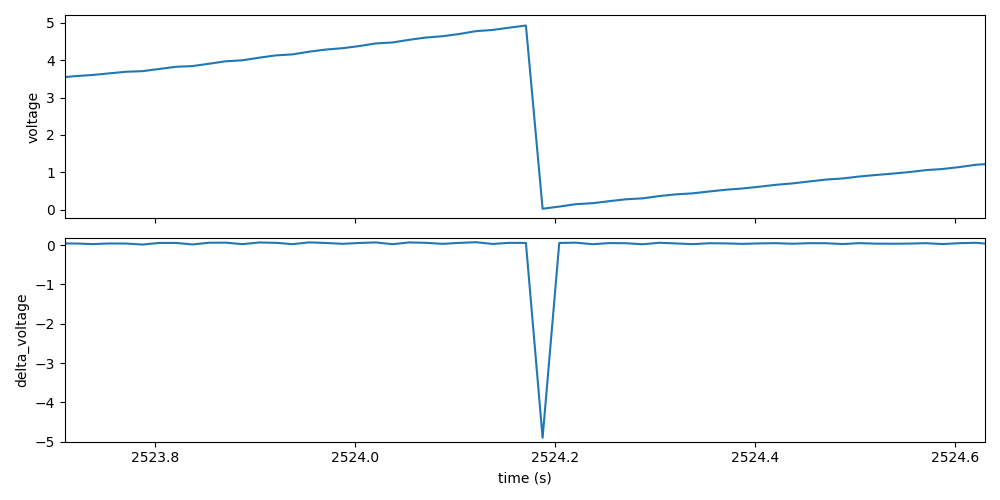

In [5]:
df = session.running_data_df.reset_index()

def identify_wraps(row,lower_threshold=1.5,upper_threshold=3.5):
    
    if row['v_sig'] < lower_threshold and row['v_sig_last'] > upper_threshold:
        return 1 # positive wrap
    elif row['v_sig'] > upper_threshold and row['v_sig_last'] < lower_threshold:
        return -1 # negative wrap
    else:
        return 0


# get the last v_sig value to facilitate diffs:
df['v_sig_last'] = df['v_sig'].shift()
df['v_sig_diff'] = df['v_sig'] - df['v_sig_last']

df['wrap_ID'] = df.apply(identify_wraps,axis=1)

# plot the diff:
fig,ax=plt.subplots(2,1,figsize=(10,5),sharex=True)

ax[0].plot(df['pkl_time'],df['v_sig'])
ax[0].set_ylabel('voltage');

ax[1].plot(df['pkl_time'],df['v_sig_diff'])
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('delta_voltage');
fig.tight_layout()

In [6]:
def calculate_wrap_corrected_diff(row):
    if row['wrap_ID'] == 1:
        # unrwap the current value, subtract the last value
        return (row['v_sig'] + row['v_in']) - row['v_sig_last']
    elif row['wrap_ID'] == -1:
        # unwrap the last value, subtract it from the current value
        return row['v_sig'] - (row['v_sig_last'] + row['v_in'])
    else:
        return row['v_sig'] - row['v_sig_last']
df['v_sig_diff_uncorrected'] = df['v_sig'] - df['v_sig_last']
df['v_sig_diff'] = df.apply(calculate_wrap_corrected_diff,axis=1)

<IPython.core.display.Javascript object>


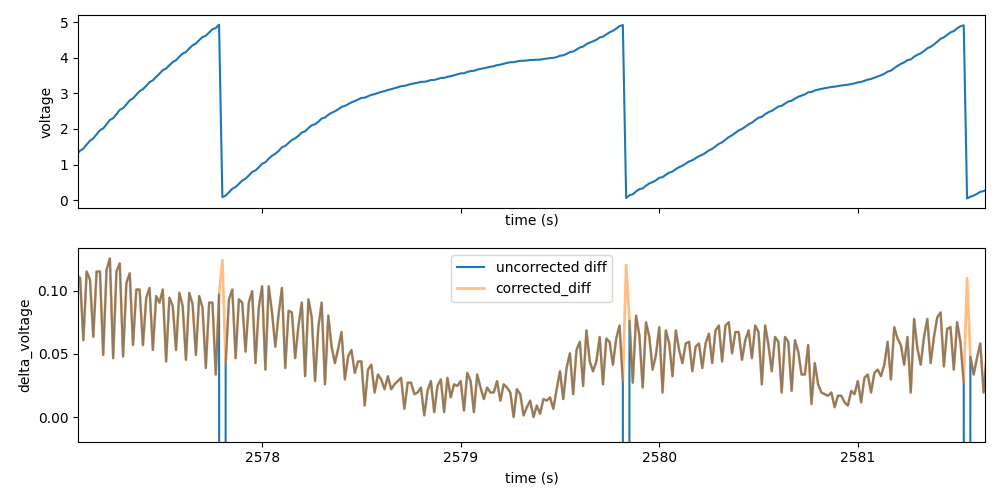

In [7]:
fig,ax=plt.subplots(2,1,figsize=(10,5),sharex=True)

ax[0].plot(df['pkl_time'],df['v_sig'])
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('voltage');

ax[1].plot(df['pkl_time'],df['v_sig_diff_uncorrected'])
ax[1].plot(df['pkl_time'],df['v_sig_diff'],linewidth=2,alpha=0.5)
ax[1].legend(['uncorrected diff','corrected_diff'])
ax[1].set_ylim(-0.2,0.2)
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('delta_voltage');
fig.tight_layout()

In [19]:
df['delta_theta'] = df['v_sig_diff']/df['v_in']*2*np.pi
df['dt'] = df['pkl_time'].diff().shift(-1) # the shift is necessary to realign the time
wheel_diameter = 6.5 * 2.54  # 6.5" wheel diameter
running_radius = 0.5 * (2.0 * wheel_diameter / 3.0)  # assume the animal runs at 2/3 the distance from the wheel center
df['speed_cm_s'] = df['delta_theta']/df['dt'] * running_radius

<IPython.core.display.Javascript object>


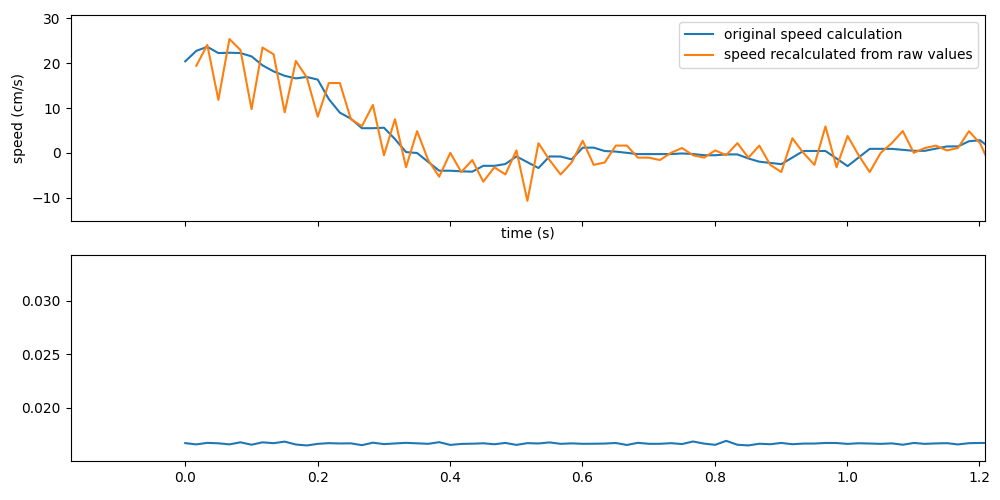

In [20]:
fig,ax=plt.subplots(2,1,figsize=(10,5),sharex=True)
ax[0].plot(df['pkl_time'],df['speed'])
ax[0].plot(df['pkl_time'],df['speed_cm_s'])
# ax.plot(df['time'],df['speed_corrected_smoothed'])

ax[0].legend(['original speed calculation','speed recalculated from raw values'],loc='best')


ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('speed (cm/s)');

ax[1].plot(df['pkl_time'].values[:-1],np.diff(df['pkl_time'].values))

fig.tight_layout()

In [47]:
df_short = df.iloc[:30].copy()
df_short['pkl_time_shifted'] = df_short['pkl_time'].shift()
df_short

,timestamps,speed,dx,v_sig,v_in,pkl_time,v_sig_last,v_sig_diff,wrap_ID,v_sig_diff_uncorrected,delta_theta,dt,speed_cm_s,pkl_time_shifted
0,7.15722,20.421354,125.526237,3.560831,4.988522,0.000000,NaN,NaN,0,NaN,NaN,0.016721,NaN,NaN
1,7.17396,22.763843,3.559072,3.607344,4.984646,0.016721,3.560831,0.046513,0,0.046513,0.058630,0.016605,19.431638,0.000000
2,7.19055,23.672121,4.336371,3.665486,4.982062,0.033326,3.607344,0.058141,0,0.058141,0.073326,0.016747,24.096656,0.016721
3,7.20729,22.264542,2.123180,3.693910,4.980770,0.050073,3.665486,0.028425,0,0.028425,0.035857,0.016705,11.813155,0.033326
4,7.22399,22.344823,4.600455,3.754635,4.976894,0.066777,3.693910,0.060725,0,0.060725,0.076664,0.016606,25.406808,0.050073
5,7.24061,22.271889,3.875665,3.810193,4.979478,0.083383,3.754635,0.055557,0,0.055557,0.070103,0.016799,22.965024,0.066777
6,7.25742,21.530022,1.753299,3.833449,4.978186,0.100183,3.810193,0.023256,0,0.023256,0.029353,0.016574,9.746802,0.083383
7,7.27399,19.530673,4.038083,3.890298,4.979478,0.116757,3.833449,0.056849,0,0.056849,0.071733,0.016796,23.504006,0.100183
8,7.29078,18.179148,3.608043,3.943271,4.983354,0.133552,3.890298,0.052973,0,0.052973,0.066790,0.016717,21.987836,0.116757
9,7.30751,17.190602,1.661011,3.965236,4.982062,0.150269,3.943271,0.021964,0,0.021964,0.027701,0.016862,9.040949,0.133552


In [22]:
df_short['v_sig'].diff()

0         NaN
1    0.046513
2    0.058141
3    0.028425
4    0.060725
5    0.055557
6    0.023256
7    0.056849
8    0.052973
9    0.021964
Name: v_sig, dtype: float64

In [24]:
df_short['dx']

0    125.526237
1      3.559072
2      4.336371
3      2.123180
4      4.600455
5      3.875665
6      1.753299
7      4.038083
8      3.608043
9      1.661011
Name: dx, dtype: float32

In [31]:
df_short['pkl_time'].diff()

0         NaN
1    0.016721
2    0.016605
3    0.016747
4    0.016705
5    0.016606
6    0.016799
7    0.016574
8    0.016796
9    0.016717
Name: pkl_time, dtype: float64

In [25]:
df_short['timestamps'].diff()

0        NaN
1    0.01674
2    0.01659
3    0.01674
4    0.01670
5    0.01662
6    0.01681
7    0.01657
8    0.01679
9    0.01673
Name: timestamps, dtype: float64

In [63]:
df_short['vsig_pkl'] = data['items']['behavior']['encoders'][0]['vsig'][:30]
df_short

,timestamps,speed,dx,v_sig,v_in,pkl_time,v_sig_last,v_sig_diff,wrap_ID,v_sig_diff_uncorrected,delta_theta,dt,speed_cm_s,pkl_time_shifted,vsig_pkl
0,7.15722,20.421354,125.526237,3.560831,4.988522,0.000000,NaN,NaN,0,NaN,NaN,0.016721,NaN,NaN,3.560831
1,7.17396,22.763843,3.559072,3.607344,4.984646,0.016721,3.560831,0.046513,0,0.046513,0.058630,0.016605,19.431638,0.000000,3.607344
2,7.19055,23.672121,4.336371,3.665486,4.982062,0.033326,3.607344,0.058141,0,0.058141,0.073326,0.016747,24.096656,0.016721,3.665486
3,7.20729,22.264542,2.123180,3.693910,4.980770,0.050073,3.665486,0.028425,0,0.028425,0.035857,0.016705,11.813155,0.033326,3.693910
4,7.22399,22.344823,4.600455,3.754635,4.976894,0.066777,3.693910,0.060725,0,0.060725,0.076664,0.016606,25.406808,0.050073,3.754635
5,7.24061,22.271889,3.875665,3.810193,4.979478,0.083383,3.754635,0.055557,0,0.055557,0.070103,0.016799,22.965024,0.066777,3.810193
6,7.25742,21.530022,1.753299,3.833449,4.978186,0.100183,3.810193,0.023256,0,0.023256,0.029353,0.016574,9.746802,0.083383,3.833449
7,7.27399,19.530673,4.038083,3.890298,4.979478,0.116757,3.833449,0.056849,0,0.056849,0.071733,0.016796,23.504006,0.100183,3.890298
8,7.29078,18.179148,3.608043,3.943271,4.983354,0.133552,3.890298,0.052973,0,0.052973,0.066790,0.016717,21.987836,0.116757,3.943271
9,7.30751,17.190602,1.661011,3.965236,4.982062,0.150269,3.943271,0.021964,0,0.021964,0.027701,0.016862,9.040949,0.133552,3.965236


<IPython.core.display.Javascript object>


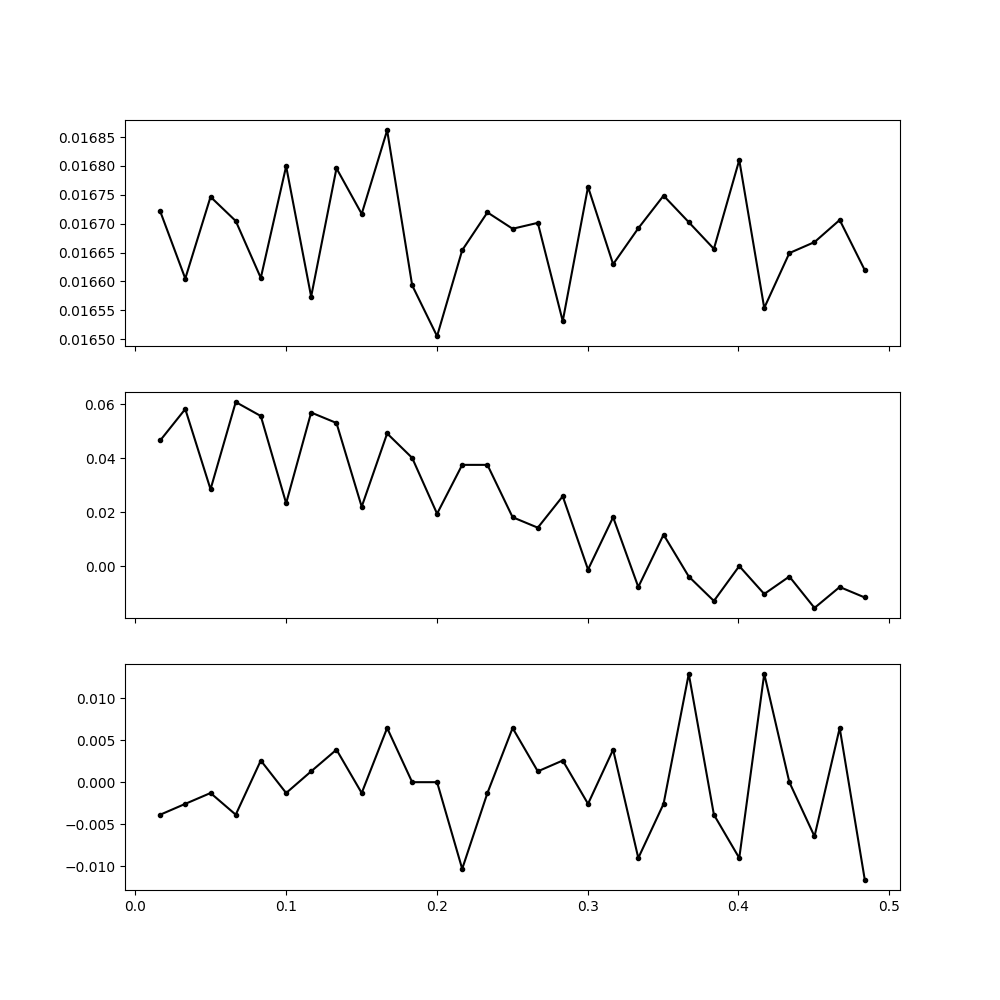

In [65]:
fig,ax = plt.subplots(3,1,figsize=(10,10),sharex=True)
ax[0].plot(
    df_short['pkl_time'],
    df_short['pkl_time'].diff(),
    '.-k'
)
ax[1].plot(
    df_short['pkl_time'],
    df_short['v_sig'].diff(),
    '.-k'
)
ax[2].plot(
    df_short['pkl_time'],
    df_short['v_in'].diff(),
    '.-k'
)

In [32]:
session.running_data_df.head()

,speed,dx,v_sig,v_in
timestamps,,,,
7.15722,20.421354,125.526237,3.560831,4.988522
7.17396,22.763843,3.559072,3.607344,4.984646
7.19055,23.672121,4.336371,3.665486,4.982062
7.20729,22.264542,2.123180,3.693910,4.980770
7.22399,22.344823,4.600455,3.754635,4.976894


In [33]:
session.stimulus_timestamps[:5]

array([7.15722021, 7.17396021, 7.19055021, 7.20729021, 7.22399021])

In [53]:

session.running_data_df.head()

269972

<IPython.core.display.Javascript object>


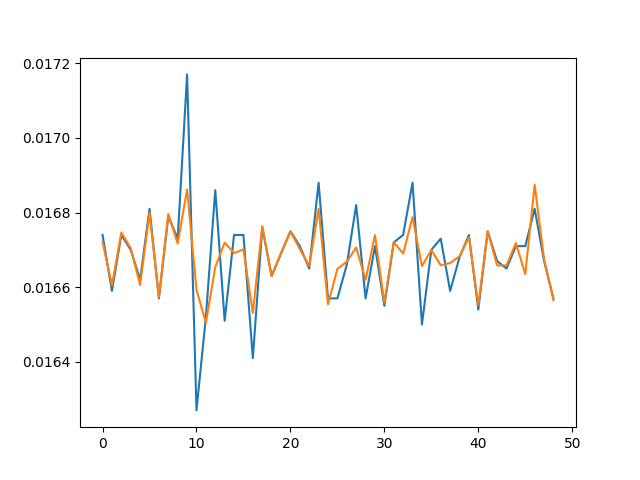

In [70]:
fig,ax=plt.subplots()
ax.plot(np.diff(session.running_data_df.reset_index()['timestamps'][:50]))
ax.plot(np.diff(session.running_data_df.reset_index()['pkl_time'][:50]))